In [1]:
import numpy as np
import matplotlib.pyplot as plt

UNITS = 1024
KER_DENSITY = 0.15
DT = 0.1
MEMBRANE_TIME_SCALE_TAU_M = 5.0
MEMBRANE_RESISTANCE_R = 500.0
V_REST = -70.0
V_RESET = -51.0
RHEOBASE_THRESHOLD_V_RH = -50.0
SHARPNESS_DELTA_T = 2.0
ADAPTATION_VOLTAGE_COUPLING_A = 0.5
ADAPTATION_TIME_CONSTANT_TAU_W = 10.0
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B = 5.0
FIRING_THRESHOLD_V_SPIKE = -30.0
SYNAPSE_STRENGTH = 30.0 / UNITS

In [ ]:
from _brian2 import brian_adex_performance_non_interactive, brian_adex_performance_interactive_mock
import brian2 as b2

k_times = [
    0.1, # [0.1ms]
    1.0, # [1ms]
    2.0, # [2ms]
    5.0, # [5ms]
    10.0, # [10ms]
]
t_max = 0.1 * b2.second

b2_times_non_inter = []
print('Brian2 (non-interactive): Running 10s simulations, 10 times each')
for k in k_times:
    times = brian_adex_performance_non_interactive(
        t_max = t_max,
        k_time = k * b2.ms,
        units = 1024,
        ker_density = 0.15,
        synapse_strength = SYNAPSE_STRENGTH,
        dt = DT * b2.ms,
        tau_m = MEMBRANE_TIME_SCALE_TAU_M * b2.ms,
        R = MEMBRANE_RESISTANCE_R * b2.Mohm,
        v_rest = V_REST * b2.mV,
        v_reset = V_RESET * b2.mV,
        v_rheobase = RHEOBASE_THRESHOLD_V_RH * b2.mV,
        a = ADAPTATION_VOLTAGE_COUPLING_A * b2.nS,
        b = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA,
        firing_threshold = FIRING_THRESHOLD_V_SPIKE * b2.mV,
        delta_T = SHARPNESS_DELTA_T * b2.mV,
        tau_w = ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms,
    )
    b2_times_non_inter.append(times)
    print(f'{k} ms steps:\t{np.mean(times):.4f} ± {np.std(times, ddof=1):.4f}')

b2_times_inter_mock = []
print('Brian2 (interactive mock): Running 10s simulations, 10 times each')
for k in k_times:
    times = brian_adex_performance_interactive_mock(
        t_max = t_max,
        k_time = k * b2.ms,
        units = 1024,
        ker_density = 0.15,
        synapse_strength = SYNAPSE_STRENGTH,
        dt = DT * b2.ms,
        tau_m = MEMBRANE_TIME_SCALE_TAU_M * b2.ms,
        R = MEMBRANE_RESISTANCE_R * b2.Mohm,
        v_rest = V_REST * b2.mV,
        v_reset = V_RESET * b2.mV,
        v_rheobase = RHEOBASE_THRESHOLD_V_RH * b2.mV,
        a = ADAPTATION_VOLTAGE_COUPLING_A * b2.nS,
        b = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA,
        firing_threshold = FIRING_THRESHOLD_V_SPIKE * b2.mV,
        delta_T = SHARPNESS_DELTA_T * b2.mV,
        tau_w = ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms,
    )
    b2_times_inter_mock.append(times)
    print(f'{k} ms steps:\t{np.mean(times):.4f} ± {np.std(times, ddof=1):.4f}')

Running 10s simulations, 10 times each


In [11]:
import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import spark
import numpy as np
from functools import partial
import time

In [ ]:
def adex_brain_config(
	units,
	ker_density,
	dt,
	synapse_strength,
	potential_rest,
	potential_reset,
	potential_tau,
	resistance, # MΩ -> GΩ
	threshold,
	rheobase_threshold,
	spike_slope,
	adaptation_tau,
	adaptation_delta,
	adaptation_subthreshold,
) -> spark.nn.BrainConfig:

	adex_config = spark.nn.neurons.AdExNeuronConfig(
		_s_units = (units,),
		_s_dt = dt,
		_s_dtype = jnp.float16,
		inhibitory_rate = 0.0,
		soma_config = spark.nn.somas.AdaptiveExponentialSomaConfig(
			potential_rest = potential_rest,
			potential_reset = potential_reset,
			potential_tau = potential_tau,
			resistance = resistance,
			threshold = threshold,
			rheobase_threshold = rheobase_threshold,
			spike_slope = spike_slope,
			adaptation_tau = adaptation_tau,
			adaptation_delta = adaptation_delta,
			adaptation_subthreshold = adaptation_subthreshold,
		),
		synapses_config = spark.nn.synapses.LinearSynapsesConfig(
			units = (units,),
			kernel_initializer = spark.nn.initializers.SparseUniformInitializerConfig(
				density = ker_density,
				scale = synapse_strength
			),
		),
		delays_config = None,
		learning_rule_config = None,
	)

	def adex_specs(name, origin, port) -> spark.ModuleSpecs:
		return spark.ModuleSpecs(
			name = name, 
			module_cls = spark.nn.neurons.AdExNeuron, 
			inputs = {
				'in_spikes': [
					spark.PortMap(origin=o, port=p) for o, p in zip(origin, port)
				]
			},
			config = adex_config
		)
	
	input_map = {
		'spikes': spark.InputSpec(
			payload_type=spark.FloatArray, 
			shape=(units,), 
			dtype=jnp.float16,
		)
	}
	output_map = {
		'spikes': {
			'input': spark.PortMap(
				origin='n_D1',
				port='out_spikes'
			),
			'spec': spark.OutputSpec(
				payload_type=spark.SpikeArray,
				shape=(units,),
				dtype=jnp.float16
			)
		}
	}
	modules_map = {
		'n_A1': adex_specs('n_A1', ['__call__'], ['spikes']),
		'n_B1': adex_specs('n_B1', ['n_A1'], ['out_spikes']),
		'n_B2': adex_specs('n_B2', ['n_B1'], ['out_spikes']),
		'n_B3': adex_specs('n_B3', ['n_B2'], ['out_spikes']),
		'n_C1': adex_specs('n_C1', ['n_A1'], ['out_spikes']),
		'n_C2': adex_specs('n_C2', ['n_C1'], ['out_spikes']),
		'n_C3': adex_specs('n_C3', ['n_C2'], ['out_spikes']),
		'n_D1': adex_specs('n_D1', ['n_B3', 'n_C3'], ['out_spikes', 'out_spikes']),
	}

	return spark.nn.BrainConfig(input_map=input_map, output_map=output_map, modules_map=modules_map)


@partial(jax.jit, static_argnames='k')
def run_model_k_steps(graph, state, k, **inputs):
    model = spark.merge(graph, state)
    for i in range(k):
        outputs = model(**inputs)
    _, state = spark.split((model))
    return outputs, state

def spark_adex_performance(
	t_steps,
	k_steps,
	units,
	ker_density,
	dt,
	synapse_strength,
	potential_rest,
	potential_reset,
	potential_tau,
	resistance,
	threshold,
	rheobase_threshold,
	spike_slope,
	adaptation_tau,
	adaptation_delta,
	adaptation_subthreshold,
):
	# Build brain
	brain_config = adex_brain_config(
		units = units,
		ker_density = ker_density,
		dt = dt,
		synapse_strength = synapse_strength,
		potential_rest = potential_rest,
		potential_reset = potential_reset,
		potential_tau = potential_tau,
		resistance = resistance,
		threshold = threshold,
		rheobase_threshold = rheobase_threshold,
		spike_slope = spike_slope,
		adaptation_tau = adaptation_tau,
		adaptation_delta = adaptation_delta,
		adaptation_subthreshold = adaptation_subthreshold,
	)
	brain = spark.nn.Brain(config=brain_config)
	brain(spikes=spark.SpikeArray( jnp.zeros((1024,), dtype=jnp.float16)) )
	graph, state = spark.split((brain))
	# Compile iteration function
	run_model_k_steps(graph, state, k_steps, spikes=spark.SpikeArray( 
		jnp.zeros((units,), dtype=jnp.float16)
	))
	# Benchmark
	times = []
	iters = (t_steps // k_steps)
	for i in range(10):
		_, state = spark.split((brain))
		start = time.time()
		# Simulate
		for i in range(iters):
			# Note: this is equivalent to passing a constant current to the input neurons for k steps.
			outputs, state = run_model_k_steps(graph, state, k_steps, spikes=spark.SpikeArray( 
				(jax.random.uniform(jax.random.key(i), (1024,)) < 0.05).astype(jnp.float16) 
			))
		end = time.time()
		times.append(end-start)

	return times

In [17]:
times = spark_adex_performance(
    t_steps = 100000, # 10s
    k_steps = 10, #1ms
	units = UNITS,
	ker_density = KER_DENSITY,
	dt = DT,
	synapse_strength = SYNAPSE_STRENGTH,
	potential_rest = V_REST,
	potential_reset = V_RESET,
	potential_tau = MEMBRANE_TIME_SCALE_TAU_M,
	resistance = MEMBRANE_RESISTANCE_R,
	threshold = FIRING_THRESHOLD_V_SPIKE,
	rheobase_threshold = RHEOBASE_THRESHOLD_V_RH,
	spike_slope = SHARPNESS_DELTA_T,
	adaptation_tau = ADAPTATION_TIME_CONSTANT_TAU_W,
	adaptation_delta = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B / 1000, # pA -> nA
	adaptation_subthreshold = ADAPTATION_VOLTAGE_COUPLING_A / 1000,	# nS -> µS
)


In [19]:
times

[5.153088808059692,
 5.246589422225952,
 5.166647672653198,
 5.158993721008301,
 5.1765220165252686,
 5.162703514099121,
 5.17735743522644,
 5.189047813415527,
 5.2003560066223145,
 5.2626354694366455]

In [7]:
int(10 * 1000 / DT)

100000

In [ ]:
k_steps = [
    1, # [0.1ms]
    10, # [1ms]
    20, # [2ms]
    50, # [5ms]
    100, # [10ms]
]

spark_times = []
print('Running 10s simulations, 10 times each')
t_max = int(10 * 1000 / DT)
for k in k_steps:
    iters = int(t_max/k)
    # Get clean state
    graph, state = spark.split((brain))
    # Compile
    outputs, state = run_model_k_steps(graph, state, k, spikes=spark.SpikeArray( jnp.ones((1024,)) ))
    k_times = []
    for i in range(10):
        start = time.time()
        # Simulate 1s
        for i in range(iters):
            # Note: this is equivalent to passing a constant current to the input neurons for k steps.
            outputs, state = run_model_k_steps(graph, state, k, spikes=spark.SpikeArray( 
                (jax.random.uniform(jax.random.key(i), (1024,)) < 0.05).astype(jnp.float16) 
            ))
        end = time.time()
        k_times.append(end-start)
    spark_times.append(k_times)
    print(f'{k} steps:\t{np.mean(k_times):.4f} ± {np.std(k_times, ddof=1):.4f}')

Running 10s simulations, 10 times each
1 steps:	41.2515 ± 0.4976
10 steps:	4.6437 ± 0.0433
20 steps:	2.4584 ± 0.0350
50 steps:	1.1661 ± 0.0106
100 steps:	0.7579 ± 0.0101


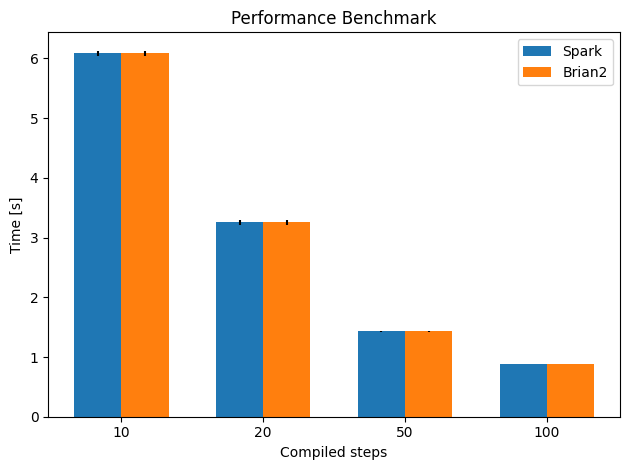

In [ ]:
import matplotlib.pyplot as plt

w = 0.333
o = w/2

plt.bar(np.arange(len(spark_times))-o, np.mean(spark_times, axis=1), yerr=np.std(spark_times, axis=1, ddof=1), width=w, label='Spark')
plt.bar(np.arange(len(b2_times))+o, np.mean(b2_times, axis=1), yerr=np.std(b2_times, axis=1, ddof=1), width=w, label='Brian2')
plt.legend()
plt.xticks(np.arange(len(spark_times)), k_steps)
plt.xlabel('Compiled steps')
plt.ylabel('Time [s]')
plt.title('Performance Benchmark')
plt.tight_layout()

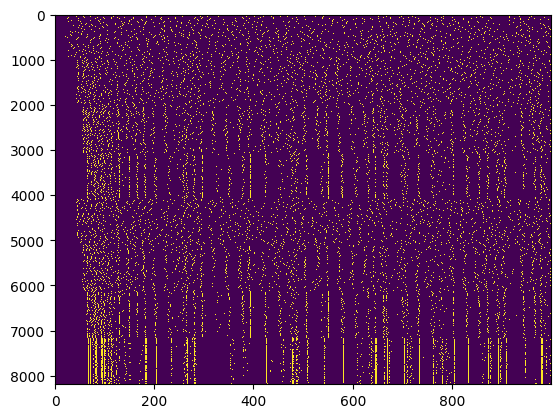

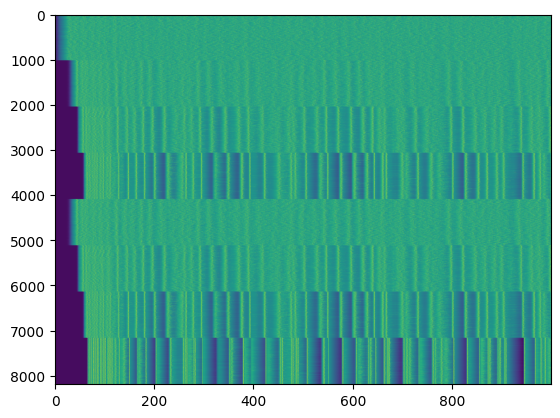

In [101]:
@partial(jax.jit, static_argnames='k')
def debug_run_model_k_steps(graph, state, k, **inputs):
    model = spark.merge(graph, state)
    for i in range(k):
        outputs = model(**inputs)
    cache_spikes = model.get_spikes_from_cache()
    spikes_from_cache = jnp.concatenate([s.value for s in cache_spikes.values()])
    pot = jnp.concatenate([
        model.n_A1.soma.potential.value,
        model.n_B1.soma.potential.value,
        model.n_B2.soma.potential.value,
        model.n_B3.soma.potential.value,
        model.n_C1.soma.potential.value,
        model.n_C2.soma.potential.value,
        model.n_C3.soma.potential.value,
        model.n_D1.soma.potential.value,
    ])
    _, state = spark.split((model))
    return outputs, state, spikes_from_cache, pot

spikes = []
pots = []
for i in range(1000):
    in_spikes = (jax.random.uniform(jax.random.key(i), (1024,)) < 0.05).astype(jnp.float16)
    outputs, state, spikes_from_cache, pot = debug_run_model_k_steps(graph, state, 1, spikes=spark.SpikeArray(in_spikes))
    spikes.append(spikes_from_cache)
    pots.append(pot)

import matplotlib.pyplot as plt
spikes = np.array(spikes)
pots = np.array(pots)
plt.imshow(spikes.T, aspect='auto', interpolation='none')
plt.show()
plt.imshow(pots.T, aspect='auto')
plt.show()

In [ ]:
if False:
    def run_model(graph, state, k, **inputs):
        model = spark.merge(graph, state)
        for i in range(k):
            outputs = model(**inputs)
        _, state = spark.split((model))
        return outputs, state

    @partial(jax.jit, static_argnames=['steps', 'unroll_steps'])
    def run_model_k_steps_fori(graph, state, steps, unroll_steps, **inputs):
        model = spark.merge(graph, state)
        jax.lax.fori_loop(0, steps, body_fun, init_val, **inputs, unroll=unroll_steps)
        for i in range(k):
            outputs = model(**inputs)
        _, state = spark.split((model))
        return outputs, state
    jax.lax.fori_loop(lower, upper, body_fun, init_val, *, unroll=None)